# Visualización y comparación de resultados de clustering
Este notebook carga las métricas producidas por **`04_cluster.py`**, muestra un resumen comparativo y genera gráficas 2‑D para inspeccionar visualmente la separación de clústeres con las diferentes combinaciones de *vectorizador + algoritmo*.

> ⬇️ *Solo necesitas ejecutar las celdas secuencialmente; ajusta los parámetros marcados como «Configuración» si quieres probar otra combinación.*

In [2]:
# --- Imports
import json, random, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
%matplotlib inline

## 1. Cargar la tabla de métricas

In [4]:
METRICS_PATH = Path('../results/basic/clustering/clustering_metrics.csv')  # ← Ajusta si es necesario
metrics_df = pd.read_csv(METRICS_PATH)
metrics_df.sort_values('silhouette', ascending=False, inplace=True)
metrics_df.head(10).fillna('-')

,method,replica,inertia,silhouette,db_score,n_noise
24,sbert,kmeans4,3323.385010,0.111896,3.737372,-
30,sbert,kmeans10,3027.378906,0.079324,3.409451,-
26,sbert,kmeans6,3189.381348,0.074507,3.672614,-
29,sbert,kmeans9,3057.836182,0.074493,3.510449,-
14,w2v,kmeans6,31.800528,0.074023,3.373376,-
17,w2v,kmeans9,30.598637,0.071590,3.314246,-
28,sbert,kmeans8,3116.315918,0.069474,3.828450,-
27,sbert,kmeans7,3148.236084,0.069175,3.558247,-
16,w2v,kmeans8,30.913059,0.066554,3.270570,-
25,sbert,kmeans5,3262.515869,0.064376,3.894980,-


### 📊 Gráfico: Silhouette por combinación

#### 📏 ¿Qué es la métrica *Silhouette*?

La métrica **Silhouette** evalúa la calidad de los clústeres generados por un algoritmo de clustering. Su valor oscila entre **-1** y **1**:

- 🟢 **Cerca de 1**: los puntos están bien agrupados dentro de su clúster y alejados de los demás. → Clustering de buena calidad
- 🟡 **Cerca de 0**: los puntos están en el límite entre clústeres. → Clustering poco definido
- 🔴 **Cerca de -1**: los puntos están probablemente mal asignados. → Clustering de mala calidad

#### 🧪 Aplicación en este proyecto

En este proyecto, calculamos la métrica *Silhouette* para cada vectorización (**TF-IDF**, **Word2Vec**, **SBERT**) combinada con cada algoritmo de clustering (**K-Means**, **DBSCAN**, **HDBSCAN**), con el fin de comparar objetivamente qué combinación agrupa mejor los textos.


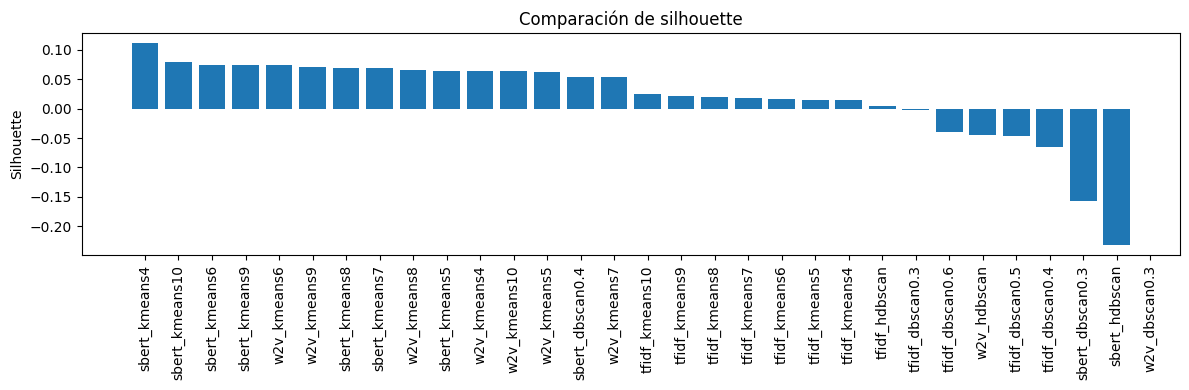

In [5]:
plt.figure(figsize=(12,4))
plt.bar(metrics_df['method']+'_'+metrics_df['replica'], metrics_df['silhouette'])
plt.xticks(rotation=90)
plt.ylabel('Silhouette')
plt.title('Comparación de silhouette')
plt.tight_layout()
plt.show()

## 2. Seleccionar la mejor combinación
Aquí elegimos la primera fila (mayor silhouette) como ejemplo, pero puedes cambiar manualmente los valores de `BEST_METHOD` y `BEST_ALGO`.

In [6]:
BEST_METHOD = metrics_df.iloc[0]['method']    # 'sbert', 'tfidf' o 'w2v'
BEST_ALGO   = metrics_df.iloc[0]['replica']      # e.g. 'kmeans7'
print('Mejor combinación:', BEST_METHOD, BEST_ALGO)

Mejor combinación: sbert kmeans4


> ✅ **Comentario**: Según la métrica *Silhouette*, la mejor combinación encontrada fue **SBERT** como método de vectorización y **K-Means con k=4** como algoritmo de agrupamiento.  
Esto sugiere que SBERT logra representar los textos de forma más adecuada para la separación de clústeres, y que dividir los datos en 4 grupos produce una estructura coherente en el espacio vectorial.


### Cargar vectores y etiquetas de clustering para Mejor combinación: sbert kmeans4

En este paso cargamos los datos que serán visualizados:

- **Vectores**: Representan los documentos procesados con una técnica de vectorización (por ejemplo, TF-IDF, Word2Vec o SBERT). Están almacenados en formato `.pkl` y pueden ser matrices dispersas (*sparse*) o densas. Si son dispersas, se convierten a matrices densas (`toarray()`) para poder ser utilizadas en tareas posteriores como reducción de dimensionalidad o visualización.

- **Etiquetas de clustering**: Son los resultados de un algoritmo de agrupamiento previamente aplicado (como K-Means, DBSCAN o HDBSCAN). Están guardadas como archivos `.csv` y se leen para asociar cada documento con el clúster al que pertenece.


In [8]:
vec_path = Path(f'../results/basic/vectorizers/{BEST_METHOD}/X_{BEST_METHOD}.pkl')
X = joblib.load(vec_path)
# Convertir sparse a denso si es necesario
if hasattr(X, 'toarray'):
    X = X.toarray()

labels_path = Path(f"../results/basic/clustering/labels_{BEST_METHOD}_{BEST_ALGO}.csv")
labels = pd.read_csv(labels_path)['label'].values
print('Vector shape:', X.shape, '| Etiquetas únicas:', np.unique(labels))

Vector shape: (4988, 768) | Etiquetas únicas: [0 1 2 3]



> **Salida**:
>
> `Vector shape: (4988, 768)` → 4988 documentos representados en 768 dimensiones (por ejemplo, embeddings de SBERT).  
> `Etiquetas únicas: [0 1 2 3]` → Se formaron 4 clústeres (numerados del 0 al 3).

### Reducción de dimensionalidad a 2‑D
Para poder **visualizar los clústeres** de documentos en un gráfico, es necesario reducir la representación vectorial a solo **2 dimensiones**. En este paso aplicamos técnicas de reducción de dimensionalidad sobre los vectores generados previamente:

- 📉 **UMAP** (`Uniform Manifold Approximation and Projection`) es preferido si está disponible, ya que preserva mejor la estructura local de los datos, incluso en espacios no lineales.
- 🔁 Si UMAP no está instalado, se utiliza **PCA** (`Principal Component Analysis`), que es más simple pero menos efectivo en datos con relaciones complejas.

El parámetro `n_components=2` indica que queremos reducir los vectores de 768 dimensiones a solo 2, permitiendo su representación en un plano 2D.


In [9]:
# Reducimos para visualizar. Usa UMAP si está instalado; si no, PCA.
REDUCE_TO = 2

if HAS_UMAP:
    reducer = umap.UMAP(n_components=REDUCE_TO, random_state=42, metric='cosine')
    X_2d = reducer.fit_transform(X)
else:
    pca = PCA(n_components=REDUCE_TO, random_state=42)
    X_2d = pca.fit_transform(X)

print('Dimensiones reducidas:', X_2d.shape)

Dimensiones reducidas: (4988, 2)


> 📌 **Ejemplo de salida**:  
> `Dimensiones reducidas: (4988, 2)`  
> Lo que significa que ahora tenemos 4988 documentos representados en dos dimensiones listas para graficarse.

### Scatter plot de los documentos en 2‑D

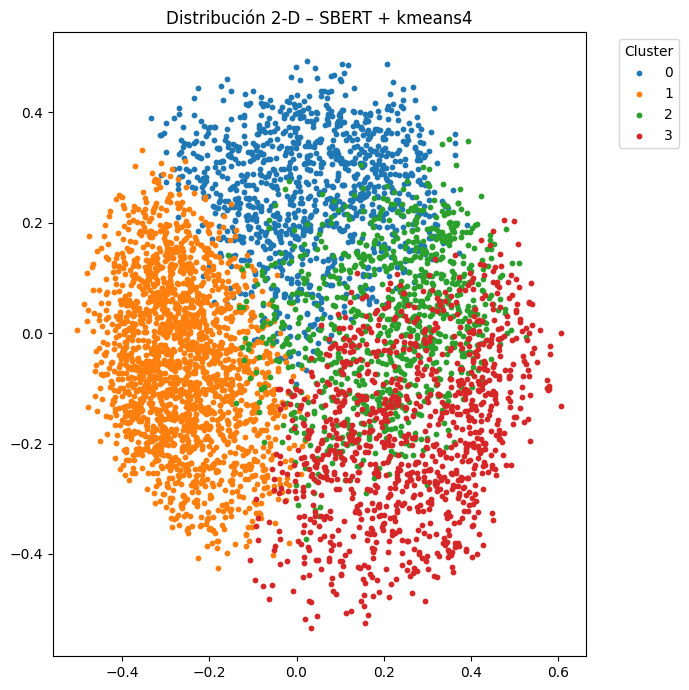

In [10]:
plt.figure(figsize=(7,7))
unique_labels = np.unique(labels)
for lab in unique_labels:
    mask = labels == lab
    plt.scatter(X_2d[mask,0], X_2d[mask,1], s=10, label=str(lab) if lab!=-1 else 'ruido')
plt.legend(title='Cluster', bbox_to_anchor=(1.05,1), loc='upper left')
plt.title(f'Distribución 2‑D – {BEST_METHOD.upper()} + {BEST_ALGO}')
plt.tight_layout()
plt.show()

## 3. Inspección rápida del contenido de un clúster
Ejecuta la celda siguiente y cambia `CLUSTER_ID` para ver algunos títulos.

In [12]:
CLUSTER_ID = unique_labels[1]   # ← Podemos modificar el cluster que querramos
doc_df = pd.read_csv('../results/tables/articulos_preprocessed_final.csv', sep=';')
mask = labels == CLUSTER_ID
doc_df[['title_processed']].iloc[np.where(mask)[0]].head(20)

,title_processed
0,functional disability patient fibromyalgia hos...
1,toothbrushing access dental service peruvian c...
2,lancet diabete endocrinology commission type d...
3,experience usual family member care receive co...
7,political socioeconomic factor shape health ta...
9,strengthen evidence inform health system oppor...
12,burden antimicrobial resistance america cross ...
13,prevalence awareness treatment control high bl...
17,lancet countdown health climate change imperat...
18,sodium content commonly consume away home food...


## 4. Estadísticas por clúster
En esta sección analizamos la cantidad de documentos asignados a cada clúster como resultado de la mejor combinación de vectorización y algoritmo de agrupamiento (`sbert + kmeans4`).

Utilizamos `collections.Counter` para contar cuántos documentos hay en cada clúster. Posteriormente, organizamos esta información en una tabla ordenada de mayor a menor cantidad de documentos.

Esta estadística es útil para identificar si los clústeres están equilibrados o si uno de ellos domina en tamaño, lo cual podría indicar una agrupación sesgada o una densidad temática muy concentrada.

In [13]:
import matplotlib.pyplot as plt

# Conteo de elementos por clúster
import collections
cluster_counts = collections.Counter(labels)

# Mostrar en tabla ordenada
pd.DataFrame.from_dict(cluster_counts, orient='index', columns=['n_documentos']) \
    .sort_values('n_documentos', ascending=False)


,n_documentos
1,1938
0,1093
3,1043
2,914


#### Visualización de la distribución
El gráfico de barras muestra cuántos artículos fueron asignados a cada clúster. Esta representación visual facilita la detección de desbalance en la agrupación. Por ejemplo, un clúster con muy pocos documentos puede sugerir un grupo temáticamente muy específico o ruido.

En nuestro caso, se observa que el clúster `1` contiene la mayor cantidad de documentos (1938), mientras que el clúster `2` es el más pequeño (914).


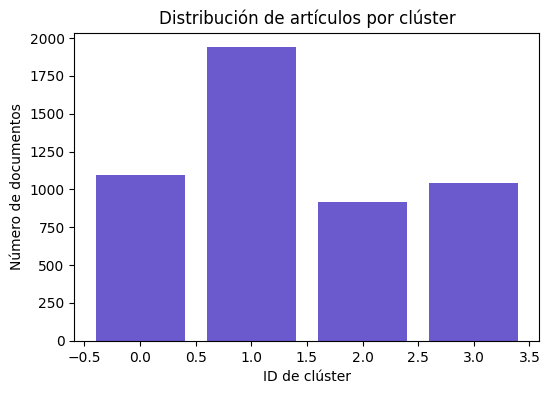

In [14]:
plt.figure(figsize=(6,4))
plt.bar(cluster_counts.keys(), cluster_counts.values(), color='slateblue')
plt.xlabel('ID de clúster')
plt.ylabel('Número de documentos')
plt.title('Distribución de artículos por clúster')
plt.show()


### Estadísticas por clúster: frecuencia de palabras

Una vez identificados los clústeres a partir de la mejor combinación (`sbert` + `kmeans4`), es fundamental explorar su contenido temático.

#### 🔹 Conteo de palabras por clúster

Se seleccionan todos los textos pertenecientes a un clúster específico (por ejemplo, el clúster 1) y se realiza un conteo de las palabras más frecuentes. Esto permite identificar rápidamente los términos predominantes dentro del grupo.

La tabla muestra las 20 palabras más frecuentes en el clúster. En este caso, destacan términos como `health`, `use`, `high`, `year` , `ci` y `peru`, lo que sugiere que los artículos agrupados en este clúster tratan temas de salud pública, investigación médica y contexto local (Perú).

In [15]:
from collections import Counter

CLUSTER_ID = 1  # cámbialo según el grupo que te interese

# Filtrar los textos del grupo seleccionado
docs = doc_df.loc[labels == CLUSTER_ID, 'abstract_processed'].dropna().tolist()

# Tokenizar y contar palabras
all_tokens = " ".join(docs).split()
top_words = Counter(all_tokens).most_common(20)

# Mostrar en tabla
pd.DataFrame(top_words, columns=['Palabra', 'Frecuencia'])


,Palabra,Frecuencia
0,health,3242
1,high,2011
2,year,1743
3,ci,1625
4,peru,1597
5,country,1582
6,risk,1524
7,age,1372
8,low,1306
9,associate,1247


#### 🔹 Visualización

El gráfico de barras horizontales permite visualizar de forma clara la importancia relativa de cada palabra. Esta representación facilita detectar rápidamente los temas clave del clúster sin necesidad de leer todos los documentos uno por uno.

Esta etapa de análisis es crucial para validar que los clústeres obtenidos no solo son estadísticamente consistentes, sino también **coherentes desde el punto de vista semántico**.

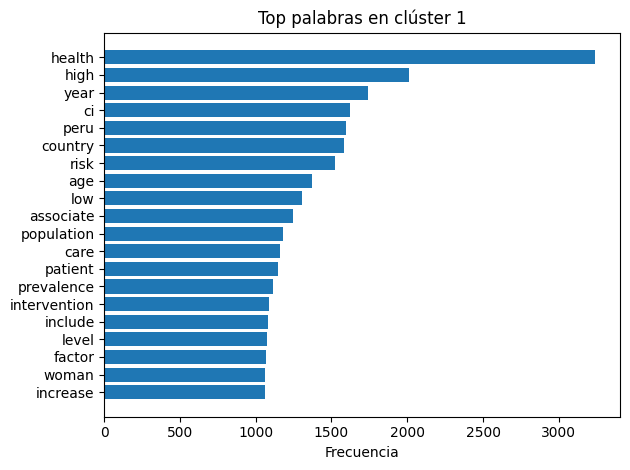

In [16]:
plt.barh([w for w, _ in reversed(top_words)], [f for _, f in reversed(top_words)])
plt.xlabel("Frecuencia")
plt.title(f"Top palabras en clúster {CLUSTER_ID}")
plt.tight_layout()
plt.show()


### 📌 Distribución temática por clúster: palabras clave más frecuentes

La siguiente visualización muestra un análisis comparativo de los términos más frecuentes en cada clúster generado mediante la mejor combinación (`SBERT + KMeans` con k=4). Cada gráfico horizontal resume las 20 palabras con mayor frecuencia dentro de los documentos agrupados en ese clúster.

#### 🔹 Clúster 0  
Este clúster está dominado por términos como `high`, `p`, `use`, `increase`, `associate`, y `disease`, lo que sugiere una agrupación centrada en enfermedades abordadas desde estudios clínicos y ensayos médicos.

#### 🔹 Clúster 1  
Aquí predominan palabras como `health`, `use`, `high`, `year`, `ci`, y `peru`. El énfasis está en el estudio de factores de riesgo alto enmarcados dentro de la salud pública peruana.

#### 🔹 Clúster 2  
Se destacan términos como `use`, `tuberculosis`, `tb`, `infection`, y `isolate`, lo cual apunta a temas relacionados con tuberculosis, diagnóstico molecular y enfermedades infecciosas.

#### 🔹 Clúster 3  
Este grupo contiene palabras como `use`, `infection`, `high`, `p`, y `peru`, sugiriendo una temática enfocada en infecciones de alto riesgo en Perú.

Sin embargo, podemos ver que hay algunas palabras repetidas en más de un clúster, lo cual puede indicar que es relevante en múltiples contextos temáticos, que hay cierta superposición entre clústeres o que no es relevante por ser de uso común. En este caso, `use` se repite en todos, por lo que podría ser considerado un stop word que no consideramos en la lista, ya que no aporta mucho a la semántica.


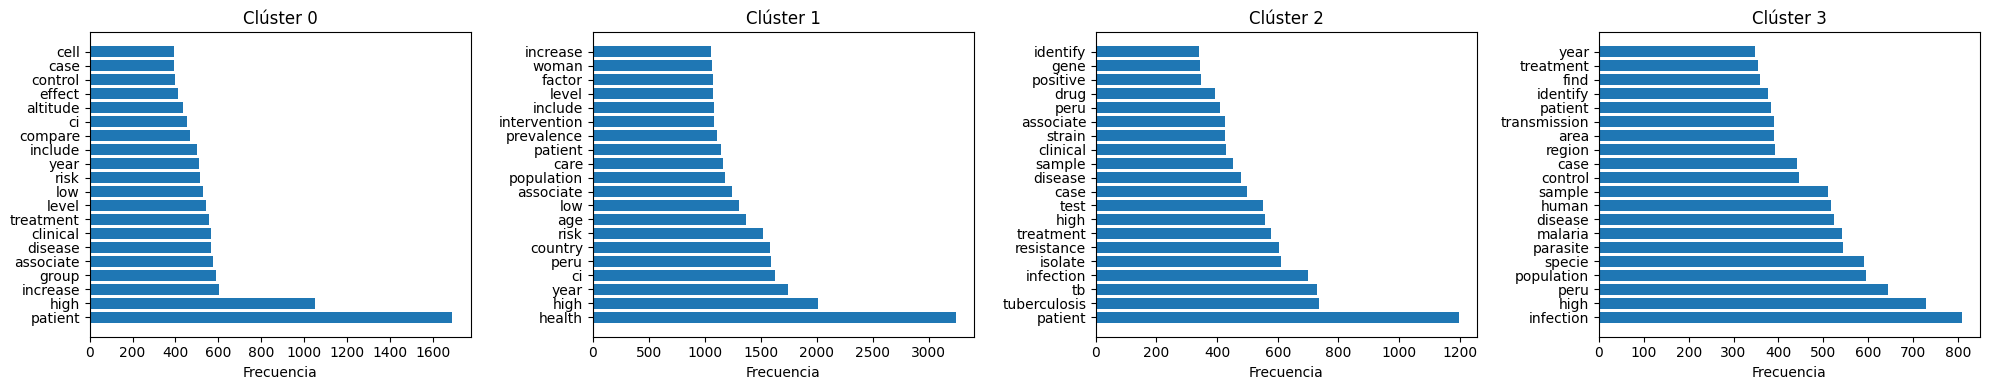

In [17]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd

# --- variables de entrada ---
texts   = doc_df['abstract_processed'].fillna('').astype(str)
clusters = np.unique(labels)              # todos los IDs de clúster
TOP_N   = 20                              # palabras a mostrar
COLS    = 4                               # nº de gráficas por fila

# --- bucle por clústeres en bloques de 4 ---
for start in range(0, len(clusters), COLS):
    fig, axes = plt.subplots(1, COLS, figsize=(COLS*5, 4))
    for j, cl in enumerate(clusters[start:start+COLS]):
        ax = axes[j]

        # 1. agrega texto del clúster
        docs = texts[labels == cl].tolist()
        tok  = " ".join(docs).split()
        top_words = Counter(tok).most_common(TOP_N)

        # 2. barplot horizontal
        words = [w for w, _ in reversed(top_words)]
        freqs = [f for _, f in reversed(top_words)]
        ax.barh(words, freqs)
        ax.set_title(f"Clúster {cl}")
        ax.set_xlabel("Frecuencia")
        ax.invert_yaxis()    # palabra + frecuente arriba

    # Si la última tanda tiene <4 clústeres, oculta ejes vacíos
    for k in range(j+1, COLS):
        axes[k].set_visible(False)

    fig.tight_layout()
    plt.show()


## 5. Resumen cualitativo rápido (títulos representativos)
### Para entender de qué trata cada clúster, podemos inspeccionar 5–10 títulos del grupo:

In [19]:
doc_df.loc[labels == CLUSTER_ID, 'title_processed'].head(10).tolist()

['functional disability patient fibromyalgia hospital lima peru',
 'toothbrushing access dental service peruvian child',
 'lancet diabete endocrinology commission type diabete look forward',
 'experience usual family member care receive community metal health center lima callao covid pandemic',
 'political socioeconomic factor shape health taxis implementation peru',
 'strengthen evidence inform health system opportunity partner accelerate progress non communicable disease',
 'burden antimicrobial resistance america cross country systematic',
 'prevalence awareness treatment control high blood pressure cohort northern andean peru',
 'lancet countdown health climate change imperative health centre response world face irreversible harm',
 'sodium content commonly consume away home food area metropolitan lima peru']

## 7. Tabla de palabras-clave por clúster

En esta sección buscamos identificar las **palabras más representativas de cada clúster** utilizando la técnica TF-IDF.

#### Idea principal:
Cada clúster es tratado como un “super-documento” al unir todos los abstracts de sus artículos. Luego se aplica TF-IDF, comparando estos super-documentos entre sí.

#### ¿Por qué usar TF-IDF aquí?
TF-IDF nos permite destacar aquellas palabras que:
- Son frecuentes dentro de un clúster (alta frecuencia local),
- Pero que no aparecen tan frecuentemente en los demás clústeres (baja frecuencia global).

Así obtenemos **palabras clave únicas por clúster**, lo que permite interpretar y etiquetar temáticamente a cada grupo.

#### Nota:
Continuamos usando la mejor combinación obtenida anteriormente (`{BEST_METHOD}` + `{BEST_ALGO}`) para garantizar coherencia en todo el análisis.


In [ ]:
"""
Objetivo
--------
Construir una tabla con las *N* palabras que mejor caracterizan cada clúster
(silhouette “ganador”: SBERT + K-means k=4).

Paso previo: define las dos constantes que usamos en todo el flujo.
"""
BEST_METHOD = "sbert"     # vectorización elegida
BEST_ALGO   = "kmeans4"   # algoritmo+parámetros ganadores
TOP_N       = 15          # nº de términos que mostraremos por clúster

# ────────────────────────────────────────────────────────────────────────── #
from pathlib import Path
import joblib, pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Cargar vectores y etiquetas de la mejor combinación
vec_path    = Path(f"../results/basic/vectorizers/{BEST_METHOD}/X_{BEST_METHOD}.pkl")
labels_path = Path(f"../results/basic/clustering/labels_{BEST_METHOD}_{BEST_ALGO}.csv")

X       = joblib.load(vec_path)
labels  = pd.read_csv(labels_path)["label"].values
if hasattr(X, "toarray"):      # TF-IDF vendría como sparse
    X = X.toarray()

print("Vector shape:", X.shape, "| Etiquetas únicas:", np.unique(labels))

# 2. Cargar los *textos* originales (abstract limpios)
docs_df = pd.read_csv("../results/tables/articulos_preprocessed_final.csv",
                      sep=";")
texts   = docs_df["abstract_processed"].fillna("").values

# 3. Construir «súper-documentos»: concatenamos todos los abstracts de un clúster
super_docs = (
    pd.DataFrame({"label": labels, "text": texts})
      .groupby("label")["text"].apply(" ".join)
      .sort_index()
)

# 4. Calcular TF-IDF entre los súper-documentos
tfidf = TfidfVectorizer(max_features=10_000,
                        stop_words="english",   # ← usa lista en inglés
                        ngram_range=(1,2),
                        min_df=2)

tfidf_matrix = tfidf.fit_transform(super_docs.values)
terms = np.array(tfidf.get_feature_names_out())

# 5. Obtener las TOP_N palabras por clúster
top_terms = {}
for idx, row in enumerate(tfidf_matrix.toarray()):
    best_idx = row.argsort()[-TOP_N:][::-1]
    top_terms[idx] = terms[best_idx]

top_terms_df = (
    pd.DataFrame(top_terms)
      .rename(columns=lambda c: f"cluster_{c}")
      .T.reset_index(drop=True)
)

# 6. Guardar y mostrar tabla
out_path = Path("../results/tables/basic/keywords_by_cluster.csv")
top_terms_df.to_csv(out_path, index=False)
print("\nTabla guardada en:", out_path)
top_terms_df.head()


Vector shape: (4988, 768) | Etiquetas únicas: [0 1 2 3]

Tabla guardada en: ..\results\tables\basic\keywords_by_cluster_basic.csv


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,patient,high,increase,group,associate,disease,clinical,treatment,level,low,risk,year,include,compare,ci
1,health,high,year,ci,peru,country,risk,age,low,associate,population,care,patient,prevalence,intervention
2,patient,tb,tuberculosis,infection,isolate,resistance,treatment,high,test,case,disease,sample,clinical,strain,associate
3,infection,high,peru,population,specie,parasite,malaria,disease,human,sample,control,case,vivax,region,transmission


### 🔍 Interpretación de **`/basic/keywords_by_cluster.csv`**

| Clúster | Palabras clave más discriminativas | Tema dominante (lectura cualitativa) |
|--------|-------------------------------------|--------------------------------------|
| **0** | high · use · increase · associate · disease · treatment · level · low · risk · year · include · compare · ci · altitude · effect | **Factores de riesgo y tratamientos en estudios clínicos**: análisis cuantitativos de variables como niveles, efectos, y asociaciones entre enfermedad, tratamiento y condiciones externas como la altitud. |
| **1** | health · use · high · year · ci · peru · country · risk · age · low · associate · care · prevalence · intervention · include | **Salud pública y epidemiología en Perú**:Estudios en factores de riesgo, prevalencia de enfermedades, intervenciones sanitarias y análisis demográficos a nivel poblacional.|
| **2** | tb · use · tuberculosis · infection · isolate · resistance · treatment · high · test · disease · strain · associate · peru · drug · positive | **Tuberculosis y resistencia a medicamentos**: estudios con énfasis en diagnóstico, aislamiento de cepas, resistencia a medicamentos y evaluación de tratamientos en contextos clínicos.|
| **3** | use · infection · high · peru · specie · parasite · malaria · disease · human · vivax · region · transmission · area · identify · treatment | **Malaria y parasitosis humanas**: Estudios centrados en parásitos como Plasmodium vivax, su transmisión regional, caracterización biológica y estrategias de tratamiento. |

---

### Detalles

- Cada fila corresponde a un clúster generado mediante **SBERT + K-means (k=4)**.
- Las palabras clave provienen de una matriz TF-IDF; las primeras en la lista son las más representativas de cada grupo temático.
- La lectura cualitativa se apoya en términos biomédicos, geográficos y de salud pública para definir los temas dominantes.

---

### Conclusión

El modelo agrupa los textos en cuatro áreas temáticas bien diferenciadas:

1. Enfermedades crónicas y sus tratamientos asociados a factores de riesgo.  
2. Salud pública en Perú, con énfasis en edad, prevalencia y cuidados.  
3. Tuberculosis, con foco en resistencia bacteriana y diagnóstico.  
4. Malaria y parasitosis tropicales, especialmente *P. vivax*, en regiones específicas.

Esto indica que la combinación de **SBERT + K-means** permite identificar clústeres temáticos con valor analítico para estudios bibliométricos o revisiones sistemáticas.


## 8. Documento **más representativo** de cada clúster  
#### (el más cercano al centroide en el espacio de embeddings)

> **Objetivo:** elegir, para cada clúster, **un único artículo** que resuma el perfil temático del grupo.  
> Este “documento prototipo” permite inspeccionar rápidamente de qué trata cada clúster sin leer cientos de abstracts.

---

### 🛠️  Metodología

1. **Vectorización usada**  
   Continuamos con la mejor configuración identificada: **SBERT + K-means k=4**.  
   Cada artículo está representado por un vector de 768 dimensiones (embeddings SBERT).

2. **Centroides de clúster**  
   Para cada clúster \(c\), el algoritmo K-means ya calcula su **centroide**  
   \[
   \boldsymbol{\mu}_c = \frac{1}{N_c}\sum_{i\in c}\mathbf{x}_i
   \]  
   donde \(N_c\) es el número de documentos y \(\mathbf{x}_i\) su embedding.

3. **Distancia al centroide**  
   - Medimos la **distancia coseno** entre cada documento y el centroide de su clúster.  
   - El documento con **menor distancia** (o, equivalentemente, mayor similitud coseno) es el **representante** del clúster.


In [ ]:
# ────────────────────────────────────────────────────────────────────────
# Elige el “documento prototipo” de cada clúster (más cercano al centroide)
# -----------------------------------------------------------------------
# • Usa la mejor configuración encontrada (SBERT + K-means k=4).
# • Devuelve un CSV con título, enlace y distancia coseno al centroide.
# -----------------------------------------------------------------------

from pathlib import Path
import joblib, numpy as np, pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# AJUSTA si cambiaste la mejor combinación
BEST_METHOD = "sbert"
BEST_ALGO   = "kmeans4"

VEC_PATH   = Path(f"../results/basic/vectorizers/{BEST_METHOD}/X_{BEST_METHOD}.pkl")
LABEL_PATH = Path(f"../results/basic/clustering/labels_{BEST_METHOD}_{BEST_ALGO}.csv")
META_PATH  = Path("../results/tables/articulos_preprocessed_final.csv")  # contiene título/link

# 1) Embeddings ----------------------------------------------------------------
X = joblib.load(VEC_PATH)
if hasattr(X, "toarray"):      # si es sparse (TF-IDF) → denso
    X = X.toarray()

# 2) Etiquetas de clúster -------------------------------------------------------
labels = pd.read_csv(LABEL_PATH)["label"].values
n_clusters = np.unique(labels).size

# 3) Metadatos (título, link, etc.) --------------------------------------------
meta_df = pd.read_csv(META_PATH, sep=";")        # ajusta separador si fuera “,”

# 4) Cálculo de centroides y búsqueda del vecino más cercano -------------------
rows = []
for c in range(n_clusters):
    idx = np.where(labels == c)[0]            # índices de docs en el clúster c
    X_c = X[idx]
    centroid = X_c.mean(axis=0, keepdims=True)

    sims = cosine_similarity(X_c, centroid).flatten()   # similitud coseno
    best_local = idx[sims.argmax()]                     # índice global

    rows.append({
        "cluster_id"   : c,
        "doc_index"    : best_local,
        "cosine_sim"   : float(sims.max()),
        "title"        : meta_df.iloc[best_local]["title_processed"],
        "link"         : meta_df.iloc[best_local].get("link", None)
    })

rep_df = pd.DataFrame(rows).sort_values("cluster_id")

# 5) Guardar y mostrar ----------------------------------------------------------
OUT_CSV = Path("../results/tables/basic/representative_docs.csv")
rep_df.to_csv(OUT_CSV, index=False, encoding="utf-8")
print(f"✅ Tabla guardada en: {OUT_CSV.resolve()}")
pd.set_option("display.max_colwidth", None)   # ‼️  None = sin límite
display(rep_df)


✅ Tabla guardada en: C:\Users\DAVID 21\OneDrive\Documentos\9no ciclo\IMLE\TextMineML\results\tables\basic\representative_docs_basic.csv


,cluster_id,doc_index,cosine_sim,title,link
0,0,4011,0.766636,identification biomedical spain latin america,None
1,1,3332,0.870275,manipulation display datum demographic family health survey program,None
2,2,4248,0.800472,detect mutation mycobacterium tuberculosis pyrazinamidase gene pnca improve infection control decrease drug resistance rate human immunodeficiency virus coinfection,None
3,3,2935,0.842421,taenia solium infection peru collaboration peace corps volunteer researcher community base,None


### 🗒️ Resultado obtenido

La tabla inferior resume el **artículo prototipo** seleccionado para cada uno de los 4 clústeres (SBERT + K-means k = 4):

| Clúster | Doc. índice | Similitud coseno | Título (resumido) |
|:-------:|:-----------:|:----------------:|-------------------|
| **0** | 4011 | 0.77 | *identification biomedical spain latin america* |
| **1** | 3332 | **0.87** | *manipulation display datum demographic family health survey r program* |
| **2** | 4248 | 0.80 | *detect mutation mycobacterium tuberculosis pyrazinamidase gene pnca… hiv coinfection* |
| **3** | 2935 | 0.84 | *taenia solium infection peru collaboration peace corps volunteer researcher community base* |

---

#### 🔍 Lectura rápida

* **Clúster 0 — “Cooperación biomédica internacional”**  
  El documento prototipo sugiere un enfoque en la *identificación y colaboración científica* entre España y América Latina, probablemente relacionado con redes académicas o iniciativas biomédicas multilaterales.

* **Clúster 1 — “Análisis poblacional y encuestas sanitarias”**  
  Similar al conjunto anterior, el documento muestra el uso de datos demográficos de encuestas de salud y su procesamiento en R, indicando un foco en *epidemiología cuantitativa y análisis de datos poblacionales*.

* **Clúster 2 — “Tuberculosis, VIH y resistencia a medicamentos”**  
  Este clúster agrupa estudios moleculares sobre mutaciones en *Mycobacterium tuberculosis* asociadas a resistencia a drogas, particularmente en *pacientes coinfectados con VIH*.

* **Clúster 3 — “Teniasis y salud comunitaria”**  
  El artículo muestra un estudio sobre *infección por Taenia solium en Perú*, con participación de voluntarios y enfoque comunitario. Indica un interés en *zoonosis, intervención local y colaboración internacional*.

---

### Cómo interpretar los valores

- **`cosine_sim`**: mide qué tan representativo es el artículo del clúster. Todos los valores > 0.75 indican buena cohesión temática.
- **`doc_index`**: corresponde al índice del artículo dentro de la matriz de embeddings, útil para recuperar metadatos o el texto completo.

---

### Conclusión

Los prototipos reflejan bien los temas dominantes en cada grupo:

1. Colaboración internacional en investigación biomédica.  
2. Análisis de datos demográficos en salud pública.  
3. TB resistente y VIH: genética y coinfección.  
4. Zoonosis e intervención comunitaria en Perú.

Estos documentos sirven como *puntos de entrada estratégicos* para revisar y explorar en profundidad los temas clave del corpus.

### 9. Palabras clave distintivas por clúster  



In [ ]:
# -------------------------------------------------------------
# Extrae las *palabras clave más distintivas* de cada clúster
# empleando TF-IDF sobre “super-documentos” (todos los abstracts
# de un clúster concatenados).
# -------------------------------------------------------------

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# ─── Parámetros globales ─────────────────────────────────────
BEST_METHOD = "sbert"     # ← mismos valores que en las secciones previas
BEST_ALGO   = "kmeans4"
N_TOP       = 20          # nº de términos por clúster a extraer

TABLE_DIR1      = Path("../results/tables/basic")
TABLE_DIR2      = Path("../results/tables")
CLUSTER_DIR    = Path("../results/basic/clustering")
OUT_CSV        = TABLE_DIR1 / "distinctive_keywords_by_cluster.csv"
ABSTRACTS_CSV  = TABLE_DIR2 / "articulos_preprocessed_final.csv"

# ─── 1. Cargar textos y etiquetas ────────────────────────────
doc_df   = pd.read_csv(ABSTRACTS_CSV, sep=";")
abstracts = doc_df["abstract_processed"].fillna("").values

labels = pd.read_csv(
    CLUSTER_DIR / f"labels_{BEST_METHOD}_{BEST_ALGO}.csv"
)["label"].values

n_clusters = labels.max() + 1

# ─── 2. Construir “super-documentos” ─────────────────────────
super_docs = [
    " ".join(abstracts[labels == c])
    for c in range(n_clusters)
]

# ─── 3. TF-IDF entre clústeres ───────────────────────────────
tfidf = TfidfVectorizer(min_df=2, max_df=0.8)
X     = tfidf.fit_transform(super_docs)
vocab = np.array(tfidf.get_feature_names_out())

# ─── 4. Seleccionar TOP-N palabras por clúster ───────────────
top_kw = {}
for c in range(n_clusters):
    row      = X[c].toarray().ravel()
    top_idx  = row.argsort()[::-1][:N_TOP]
    top_kw[c] = vocab[top_idx]

keywords_df = (
    pd.DataFrame
      .from_dict(top_kw, orient="index")
      .rename_axis("cluster_id")
)

# ─── 5. Guardar y mostrar resultado ──────────────────────────
keywords_df.to_csv(OUT_CSV)
print(f"✅  Tabla guardada en: {OUT_CSV.resolve()}")
keywords_df

✅  Tabla guardada en: C:\Users\DAVID 21\OneDrive\Documentos\9no ciclo\IMLE\TextMineML\results\tables\basic\distinctive_keywords_by_cluster_basic.csv


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cluster_id,,,,,,,,,,,,,,,,,,,,
0,cms,hypoxia,sle,stroke,lupus,ee,ha,sleep,implant,sea,lowlander,erythrocytosis,maca,testosterone,placebo,sperm,prostate,fluoride,sickness,apnea
1,tb,obesity,overweight,stroke,adolescent,msm,prep,diabetes,violence,sleep,ptsd,depressive,fuel,smoking,stove,tw,government,caregiver,copd,cultural
2,tb,sputum,mutation,mycobacterium,mdr,mic,microscopy,mtb,multidrug,isoniazid,dst,syphilis,xpert,pallidum,rifampicin,candidemia,pyrazinamide,spp,ciprofloxacin,rif
3,vivax,solium,leishmania,cruzi,sediment,microscopy,mosquito,larvae,sea,taeniasis,spp,outbreak,tapeworm,lu,helminth,marine,insect,polymorphism,dengue,organic


### 🗒️ Resultado obtenido

La tabla inferior muestra los **20 términos TF-IDF con mayor peso** para cada uno de los cuatro clústeres generados con **SBERT + K-means (k = 4)**:

| cluster_id | 0 | 1 | 2 | 3 | 4 | … | 19 |
|------------|---|---|---|---|---|---|----|
| **0** | cms | hypoxia | sle | stroke | lupus | … | apnea |
| **1** | tb | obesity | overweight | stroke | adolescent | … | cultural |
| **2** | tb | sputum | mutation | mycobacterium | mdr | … | rif |
| **3** | vivax | solium | leishmania | cruzi | sediment | … | organic |

---

#### 📖 Lectura rápida de los temas

| Clúster | Indicadores léxicos | Posible temática |
|---------|---------------------|------------------|
| **0** | *cms, hypoxia, sle, stroke, lupus, erythrocytosis, implant, testosterone, prostate, placebo, apnea…* | **Medicina clínica**: enfermedades autoinmunes, cardiovasculares y salud reproductiva masculina. |
| **1** | *tb, obesity, adolescent, msm, prep, diabetes, violence, depression, smoking, ptsd, stove, caregiver…* | **Salud pública y factores sociales**: enfermedades crónicas, salud mental y contextos vulnerables. |
| **2** | *tb, sputum, mutation, mycobacterium, mdr, microscopy, xpert, isoniazid, rifampicin, dst, candidemia…* | **Tuberculosis y resistencia antimicrobiana**: diagnóstico molecular y coinfecciones. |
| **3** | *vivax, solium, leishmania, cruzi, mosquito, taeniasis, helminth, larvae, spp, polymorphism, dengue…* | **Parasitología tropical**: malaria, helmintiasis y vectores en entornos amazónicos. |

---

### 🧾 Detalles

> *Cada fila* corresponde a un clúster y muestra sus **20 términos TF-IDF con mayor peso**.  
> Estas palabras destacan porque son **frecuentes dentro del grupo pero poco comunes en los demás**, por lo que “definen” el tema central de cada clúster.

---

#### 💡 Cómo podemos aprovechar esta tabla

- **Etiquetado rápido**: permite asignar nombres significativos a los clústeres sin leer todos los artículos.
- **Filtrado temático**: ayuda a seleccionar documentos que contengan alguna de estas palabras clave.
- **Validación del clustering**: si las palabras clave no guardan coherencia temática, puede ser señal de revisar parámetros del modelo.

---

> **🧪 Nota metodológica**  
> Las palabras se obtuvieron concatenando los abstracts de cada clúster en un “super-documento” y aplicando **TF-IDF entre clústeres**.  
> Se muestran los 20 términos con valores TF-IDF más altos por fila.

---

### ✅ Conclusión

La separación temática entre los clústeres es clara y coherente:

1. **Clínica médica**: autoinmunidad, cardiología, urología, hormonas.  
2. **Salud pública**: enfermedades crónicas, salud mental y desigualdad.  
3. **Tuberculosis**: mutaciones, pruebas moleculares y resistencia.  
4. **Parasitología tropical**: malaria, helmintos y vectores amazónicos.

Este tipo de análisis facilita una visión general del corpus y permite priorizar clústeres para revisión más profunda.


# Word-clouds de las *palabras clave distintivas* por clúster

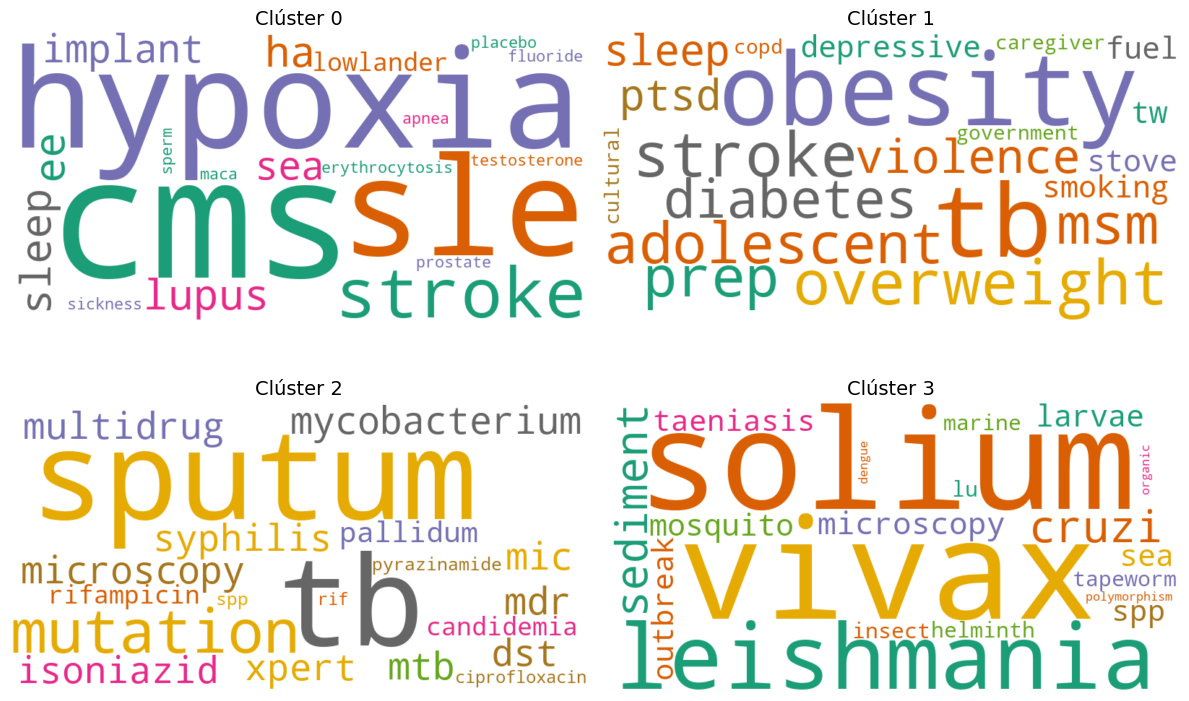

In [24]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ─── Parámetros ─────────────────────────────────────────────
CSV_PATH  = Path("../results/tables/basic/distinctive_keywords_by_cluster.csv")
FIGSIZE   = (12, 8)    # tamaño de la figura
WC_KWARGS = dict(
    width=800,
    height=400,
    background_color="white",
    colormap="Dark2"   # ← ¡ojo a la D mayúscula!
)

# ─── Cargar datos ───────────────────────────────────────────
kw_df      = pd.read_csv(CSV_PATH, index_col=0)
n_clusters = kw_df.shape[0]

# ─── Crear grid de subplots ─────────────────────────────────
cols = 2
rows = (n_clusters + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=FIGSIZE)
axes = axes.flatten()

for c, ax in enumerate(axes):
    if c >= n_clusters:
        ax.axis("off")
        continue

    text = " ".join(kw_df.loc[c].dropna().values)
    wc   = WordCloud(**WC_KWARGS).generate(text)

    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Clúster {c}", fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()